# Santander Customer Satisfaction - Classification

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropCorrelatedFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    train_test_split
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE



seed = 42
random.seed(seed)
np.random.seed(seed)

import os
os.environ["PYTHONWARNINGS"] = "ignore" # ignore warnings on multiprocessing units

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 9999)
pd.set_option("display.max_columns", 9999)

In [2]:
def reduce_mem_usage(df):
    numerics = df.select_dtypes(include=[int, float]).columns.to_list()
    ints = (np.iinfo(np.int8), np.iinfo(np.int16), np.iinfo(np.int32), np.iinfo(np.int64))
    floats = (np.finfo(np.float16), np.finfo(np.float32), np.finfo(np.float64), np.finfo(np.float128))

    for col in numerics:
        min_val = df[col].min()
        max_val = df[col].max()

        if "int" in df[col].dtype.name:
            for info in ints:
                if min_val >= info.min and max_val <= info.max:
                    df[col] = df[col].astype(info.dtype)
                    break
        else:
            for info in floats:
                if min_val >= info.min and max_val <= info.max:
                    df[col] = df[col].astype(info.dtype)
                    break

    return df

In [3]:
df_train = reduce_mem_usage(pd.read_csv("../input/santander-customer-satisfaction/train.csv"))
df_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

In [4]:
df_train.shape

(76020, 371)

In [5]:
df_train.dtypes

ID                                 int32
var3                               int32
var15                               int8
imp_ent_var16_ult1               float32
imp_op_var39_comer_ult1          float16
imp_op_var39_comer_ult3          float16
imp_op_var40_comer_ult1          float16
imp_op_var40_comer_ult3          float16
imp_op_var40_efect_ult1          float16
imp_op_var40_efect_ult3          float16
imp_op_var40_ult1                float16
imp_op_var41_comer_ult1          float16
imp_op_var41_comer_ult3          float16
imp_op_var41_efect_ult1          float16
imp_op_var41_efect_ult3          float32
imp_op_var41_ult1                float16
imp_op_var39_efect_ult1          float16
imp_op_var39_efect_ult3          float32
imp_op_var39_ult1                float16
imp_sal_var16_ult1               float32
ind_var1_0                          int8
ind_var1                            int8
ind_var2_0                          int8
ind_var2                            int8
ind_var5_0      

# Data Cleaning

In [6]:
print(f"There are {df_train.isnull().sum().sum()} columns with missing values.")

There are 0 columns with missing values.


In [7]:
print(f"The dataset contains {df_train.duplicated().sum()} duplicated rows.")

The dataset contains 0 duplicated rows.


In [8]:
nunique = df_train.nunique().sort_values(ascending=True)
nunique.head(50)

ind_var41                        1
num_var46                        1
imp_amort_var18_hace3            1
num_var28_0                      1
num_var28                        1
num_var27                        1
ind_var27                        1
ind_var28                        1
ind_var28_0                      1
ind_var2                         1
ind_var27_0                      1
saldo_var41                      1
num_reemb_var13_hace3            1
num_var41                        1
num_reemb_var33_hace3            1
saldo_var27                      1
saldo_var28                      1
num_trasp_var17_out_hace3        1
num_var46_0                      1
saldo_var46                      1
ind_var2_0                       1
imp_amort_var34_hace3            1
num_var27_0                      1
ind_var46_0                      1
num_var2_ult1                    1
num_var2_0_ult1                  1
ind_var46                        1
imp_reemb_var13_hace3            1
num_trasp_var33_out_

In [9]:
df_train.dtypes.value_counts()

int8       209
float32     79
float16     32
int16       30
int64       16
int32        5
dtype: int64

# Data Exploration

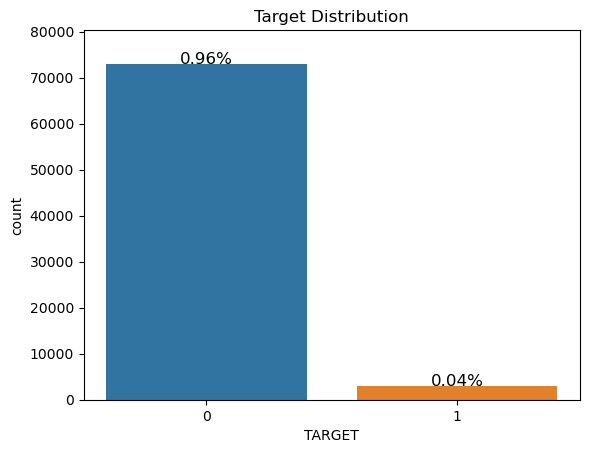

In [10]:
target_counts = df_train["TARGET"].value_counts().sort_index().to_frame(name="count").reset_index(names=["TARGET"])

plt.title("Target Distribution")
ax = sns.barplot(data=target_counts, x="TARGET", y="count")

for i, p in enumerate(ax.patches):
    ax.annotate(
        np.round(target_counts["count"].iloc[i] / target_counts["count"].sum(), 2).astype(str) + "%",
        ((p.get_x() + p.get_width() / 2), p.get_height() + 0.05),
        ha="center",
        size=12
    )

plt.margins(0.05, 0.1)
plt.show()

# Preprocessing

In [11]:
X, y = df_train.drop(["TARGET", "ID"], axis=1), df_train["TARGET"]

### Feature Selection

In [12]:
constant_features = DropConstantFeatures(tol=0.999, missing_values="raise")
constant_features.fit(X, y)
print(f"{len(constant_features.features_to_drop_)} of constant features to be dropped")
X_selected = constant_features.transform(X)

146 of constant features to be dropped


In [13]:
duplicate_features = DropDuplicateFeatures(missing_values="raise")
duplicate_features.fit(X_selected, y)
print(f"{len(duplicate_features.features_to_drop_)} of duplicated features to be dropped")
X_selected = duplicate_features.transform(X_selected)

10 of duplicated features to be dropped


In [14]:
rf = RandomForestClassifier(max_depth=3, n_estimators=100, criterion="gini", random_state=seed)
rf.fit(X_selected, y)
feature_importances = pd.Series(data=rf.feature_importances_, index=rf.feature_names_in_)
feature_importances.sort_values(ascending=True)

ind_var9_ult1                    0.000000
num_var13_largo                  0.000000
saldo_var31                      0.000000
num_var13_corto_0                0.000000
saldo_var32                      0.000000
saldo_var40                      0.000000
num_meses_var12_ult3             0.000000
num_meses_var13_corto_ult3       0.000000
saldo_medio_var12_hace3          0.000000
num_var14_0                      0.000000
num_meses_var13_largo_ult3       0.000000
ind_var44_0                      0.000000
ind_var41_0                      0.000000
num_var43_recib_ult1             0.000000
ind_var40_0                      0.000000
ind_var37_cte                    0.000000
ind_var32_0                      0.000000
ind_var31                        0.000000
ind_var31_0                      0.000000
ind_var44                        0.000000
num_var14                        0.000000
num_var17_0                      0.000000
num_var20                        0.000000
saldo_medio_var44_ult3           0

In [15]:
zero_importance_features = feature_importances[feature_importances == 0]
len(zero_importance_features)

76

In [16]:
X_selected.drop(zero_importance_features.index, axis=1, inplace=True)

In [17]:
# from boruta import BorutaPy

# boruta = BorutaPy(
#     rf,
#     n_estimators="auto",
#     random_state=seed
# )

# boruta = boruta.fit(X_selected.values, y.values)

In [18]:
# X_selected.columns[boruta.support_]

In [19]:
# X_selected.drop(X_selected.columns[boruta.support_], axis=1, inplace=True)

In [20]:
correlated_features = DropCorrelatedFeatures(method="pearson", threshold=0.95, missing_values="raise")
correlated_features.fit(X_selected, y)
print(f"{len(correlated_features.features_to_drop_)} of highly correlated features to be dropped")
X_selected = correlated_features.transform(X_selected)

36 of highly correlated features to be dropped


### Selected Features

In [21]:
selected_features = X_selected.columns.values
selected_features

array(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_ult1',
       'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3',
       'imp_op_var41_ult1', 'imp_sal_var16_ult1', 'ind_var5_0',
       'ind_var5', 'ind_var8_0', 'ind_var8', 'ind_var12_0', 'ind_var12',
       'ind_var13_0', 'ind_var13_corto', 'ind_var20_0', 'ind_var20',
       'ind_var24', 'ind_var25_cte', 'ind_var25_0', 'ind_var30_0',
       'ind_var30', 'ind_var32_cte', 'ind_var37_0', 'ind_var39_0',
       'ind_var40', 'num_var1_0', 'num_var4', 'num_var5_0', 'num_var12_0',
       'num_var13_largo_0', 'num_var17', 'num_var24_0', 'num_var25_0',
       'num_op_var40_ult1', 'num_op_var41_hace2', 'num_op_var41_hace3',
       'num_op_var41_ult1', 'num_op_var41_ult3', 'num_var30_0',
       'num_var30', 'num_var37_med_ult2', 'num_var37_0', 'num_var39_0',
       'num_var42_0', 'num_var42', 'saldo_var1', 'saldo_var5',
       'saldo_var8', 'saldo_var12', 'saldo_var13', 'sa

# Modeling

In [22]:
sample = df_train.sample(n=20000, random_state=seed)
scaler = StandardScaler()
X, y = sample[selected_features], sample["TARGET"]
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=seed)

In [23]:
oversampling = SMOTE(random_state=seed)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
scoring = "f1"

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=seed),
    "DT": DecisionTreeClassifier(random_state=seed),
    "SVM": SVC(max_iter=1000, random_state=seed),
    "Naive Bayes": GaussianNB(),
    "RF": RandomForestClassifier(random_state=seed),
    "XGBoost": XGBClassifier(seed=seed),
    "LightGBM": LGBMClassifier(random_state=seed)
}

score_results = []
for model in models.values():
    pipe = ImbPipeline(steps=[
        ("oversampling", oversampling),
        ("clf", model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, scoring=scoring, n_jobs=-1)
    score_results.append(scores)

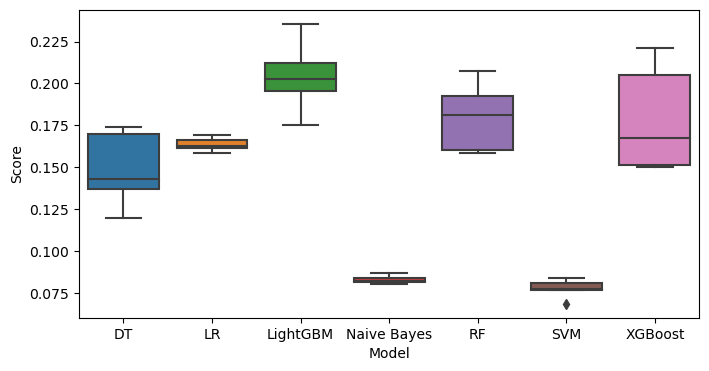

In [24]:
scores_df = pd.DataFrame(score_results, columns=[i for i in range(1, 6)])
scores_df["Model"] = list(models.keys())
scores_df = pd.melt(frame=scores_df, id_vars=["Model"], value_vars=[i for i in range(1, 6)], var_name="Fold", value_name="Score").sort_values(["Model", "Fold"], ascending=True)
plt.figure(figsize=(8, 4))
sns.boxplot(data=scores_df, x="Model", y="Score")
plt.show()

In [25]:
scores_df.groupby("Model")["Score"].mean().sort_values(ascending=False)

Model
LightGBM       0.204349
RF             0.180089
XGBoost        0.179131
LR             0.163563
DT             0.148913
Naive Bayes    0.082975
SVM            0.077546
Name: Score, dtype: float64

In [27]:
from sklearn.model_selection import RandomizedSearchCV

pipe = ImbPipeline(steps=[
    ("oversampling", SMOTE(random_state=seed)),
    ("clf", LGBMClassifier(random_state=seed))
])

search = RandomizedSearchCV(
    pipe,
    param_distributions={
        "oversampling__k_neighbors": np.arange(3, 10),
        "oversampling__sampling_strategy": ["auto"] + list(np.arange(0.4, 1.1, 0.1)),
        "clf__n_estimators": np.arange(100, 1100, 100),
        "clf__max_depth": np.arange(2, 10),
        "clf__learning_rate": [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9],
        "clf__colsample_bytree": np.arange(0.5, 1.1, 0.1),
        "clf__subsample": np.arange(0.5, 1.1, 0.1)
    },
    cv=cv,
    scoring=scoring,
    n_iter=300,
    n_jobs=-1
)

search = search.fit(X_train, y_train)

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 357 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 357 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /__w/1/s/pyt

In [28]:
from sklearn.base import clone

model = clone(search.best_estimator_)
train_preds = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1)

model.fit(X_train, y_train)
test_preds = model.predict(X_test)

def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

metrics_df = pd.DataFrame(columns=["Train", "Test"], index=["Accuracy", "Precision", "Recall", "F1-Score"])
metrics_df["Train"] = metrics(y_train, train_preds)
metrics_df["Test"] = metrics(y_test, test_preds)
metrics_df

,Train,Test
Accuracy,0.901667,0.903200
Precision,0.181619,0.166667
Recall,0.413621,0.355000
F1-Score,0.252408,0.226837
